In [1]:
import zipfile
import requests
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os

In [2]:
#!pip install ultralytics

## Visualize Images from the Dataset

In [3]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [4]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [5]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[1:]
                #print(bbox_string.split(' '))
                empty_par,x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

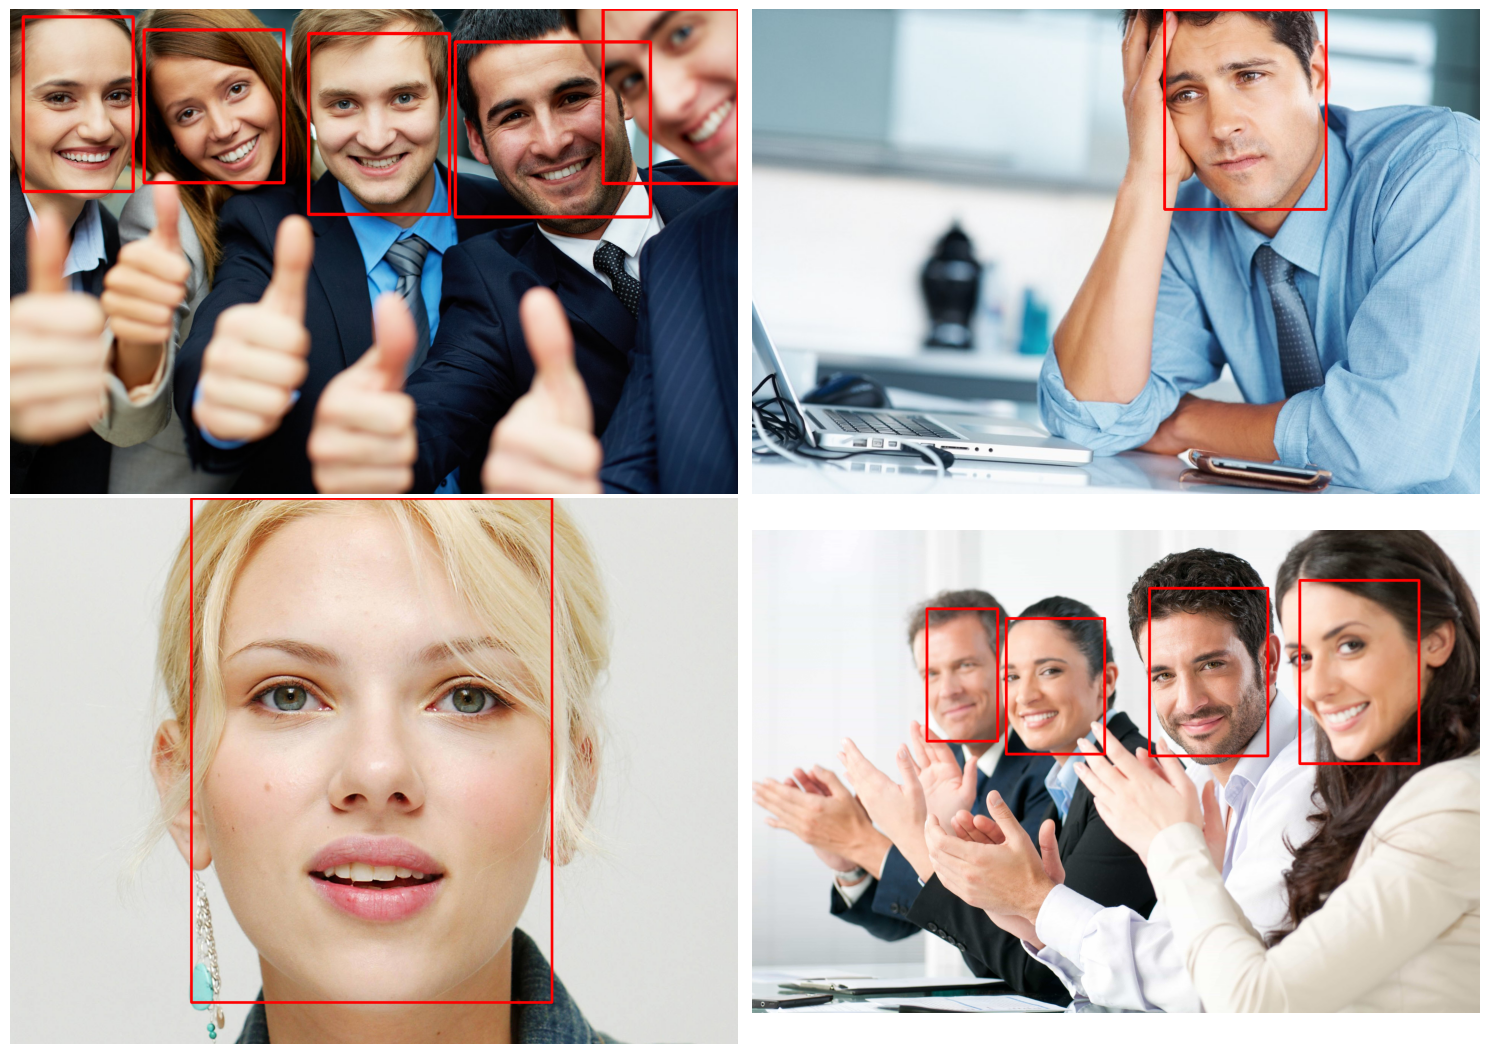

In [6]:
# Visualize a few training images.
plot(
    image_paths='datasets/train/images/',
    label_paths='datasets/train/labels/',
    num_samples=4,
)

## Dataset YAML File

In [7]:
%%writefile yaml.yaml

train: 'train/images'
val: 'valid/images'

# class names
names:
    0 : 'face'


Overwriting yaml.yaml


## YOLOv8 Nano Training

In [8]:
# Sample training for 5 epoch.
EPOCHS = 5
!yolo task=detect mode=train model=yolov8m.pt imgsz=1280 data=yaml.yaml epochs={EPOCHS} batch=8 name=yolov8m_v8_50e

Ultralytics YOLOv8.0.227 рџљЂ Python-3.8.10 torch-2.1.2+cpu CPU (13th Gen Intel Core(TM) i9-13900K)
engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=yaml.yaml, epochs=5, patience=50, batch=8, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8m_v8_50e7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=to


train: Scanning C:\Users\gribo\OneDrive\Рабочий стол\Lab4\datasets\train\labels.cache... 36 images, 0 backgrounds, 0 corrupt: 100%|##########| 36/36 [00:00<?, ?it/s]
train: Scanning C:\Users\gribo\OneDrive\Рабочий стол\Lab4\datasets\train\labels.cache... 36 images, 0 backgrounds, 0 corrupt: 100%|##########| 36/36 [00:00<?, ?it/s]

val: Scanning C:\Users\gribo\OneDrive\Рабочий стол\Lab4\datasets\valid\labels.cache... 5 images, 0 backgrounds, 0 corrupt: 100%|##########| 5/5 [00:00<?, ?it/s]
val: Scanning C:\Users\gribo\OneDrive\Рабочий стол\Lab4\datasets\valid\labels.cache... 5 images, 0 backgrounds, 0 corrupt: 100%|##########| 5/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]
        1/5         0G      2.441       5.47      2.948         19       1280:   0%|          | 0/5 [00:29<?, ?it/s]
        1/5         0G      2.441       5.47      2.948         19       1280:  20%|##        | 1/5 [00:29<01:56, 29.15s/it]
        1/5         0G      2.241      5.109      2.792        

## Evaluation on Validation Images

In [9]:
!yolo task=detect mode=val model=runs/detect/yolov8m_v8_50e6/weights/best.pt name=yolov8m_eval data=yaml.yaml

Ultralytics YOLOv8.0.227 рџљЂ Python-3.8.10 torch-2.1.2+cpu CPU (13th Gen Intel Core(TM) i9-13900K)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs
                   all          5          8          1      0.864      0.955      0.618
Speed: 3.1ms preprocess, 427.1ms inference, 0.0ms loss, 13.7ms postprocess per image
Results saved to runs\detect\yolov8m_eval2
рџ’Ў Learn more at https://docs.ultralytics.com/modes/val



val: Scanning C:\Users\gribo\OneDrive\Рабочий стол\Lab4\datasets\valid\labels.cache... 5 images, 0 backgrounds, 0 corrupt: 100%|##########| 5/5 [00:00<?, ?it/s]
val: Scanning C:\Users\gribo\OneDrive\Рабочий стол\Lab4\datasets\valid\labels.cache... 5 images, 0 backgrounds, 0 corrupt: 100%|##########| 5/5 [00:00<?, ?it/s]

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/1 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|##########| 1/1 [00:02<00:00,  2.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|##########| 1/1 [00:02<00:00,  2.40s/it]


## Inference on Validation Images

In [10]:
!yolo task=detect \
mode=predict \
model=runs/detect/yolov8m_v8_50e6/weights/best.pt \
source=datasets/valid/images \
imgsz=1280 \
name=yolov8m_v8_50e_infer1280 \
hide_labels=True

WARNING вљ пёЏ 'hide_labels' is deprecated and will be removed in 'ultralytics 8.2' in the future. Please use 'show_labels' instead.
Ultralytics YOLOv8.0.227 рџљЂ Python-3.8.10 torch-2.1.2+cpu CPU (13th Gen Intel Core(TM) i9-13900K)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs

image 1/5 C:\Users\gribo\OneDrive\Р Р°Р±РѕС‡РёР№ СЃС‚РѕР»\Lab4\datasets\valid\images\1 (37).jpg: 864x1280 2 faces, 267.5ms
image 2/5 C:\Users\gribo\OneDrive\Р Р°Р±РѕС‡РёР№ СЃС‚РѕР»\Lab4\datasets\valid\images\1 (38).jpg: 1280x1280 1 face, 367.5ms
image 3/5 C:\Users\gribo\OneDrive\Р Р°Р±РѕС‡РёР№ СЃС‚РѕР»\Lab4\datasets\valid\images\1 (39).jpg: 864x1280 4 faces, 245.0ms
image 4/5 C:\Users\gribo\OneDrive\Р Р°Р±РѕС‡РёР№ СЃС‚РѕР»\Lab4\datasets\valid\images\1 (40).jpg: 864x1280 3 faces, 245.1ms
image 5/5 C:\Users\gribo\OneDrive\Р Р°Р±РѕС‡РёР№ СЃС‚РѕР»\Lab4\datasets\valid\images\1 (41).jpg: 1280x1088 1 face, 309.5ms
Speed: 5.6ms preprocess, 286.9ms inference, 1.0ms postprocess per imag

## Visualize Validation Results

In [11]:
# Plot and visualize images in a 2x2 grid.
def visualize(result_dir, num_samples=4):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid.
    """
    plt.figure(figsize=(20, 12))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.axis('off')
        if i == num_samples-1:
            break
    plt.tight_layout()
    plt.show()

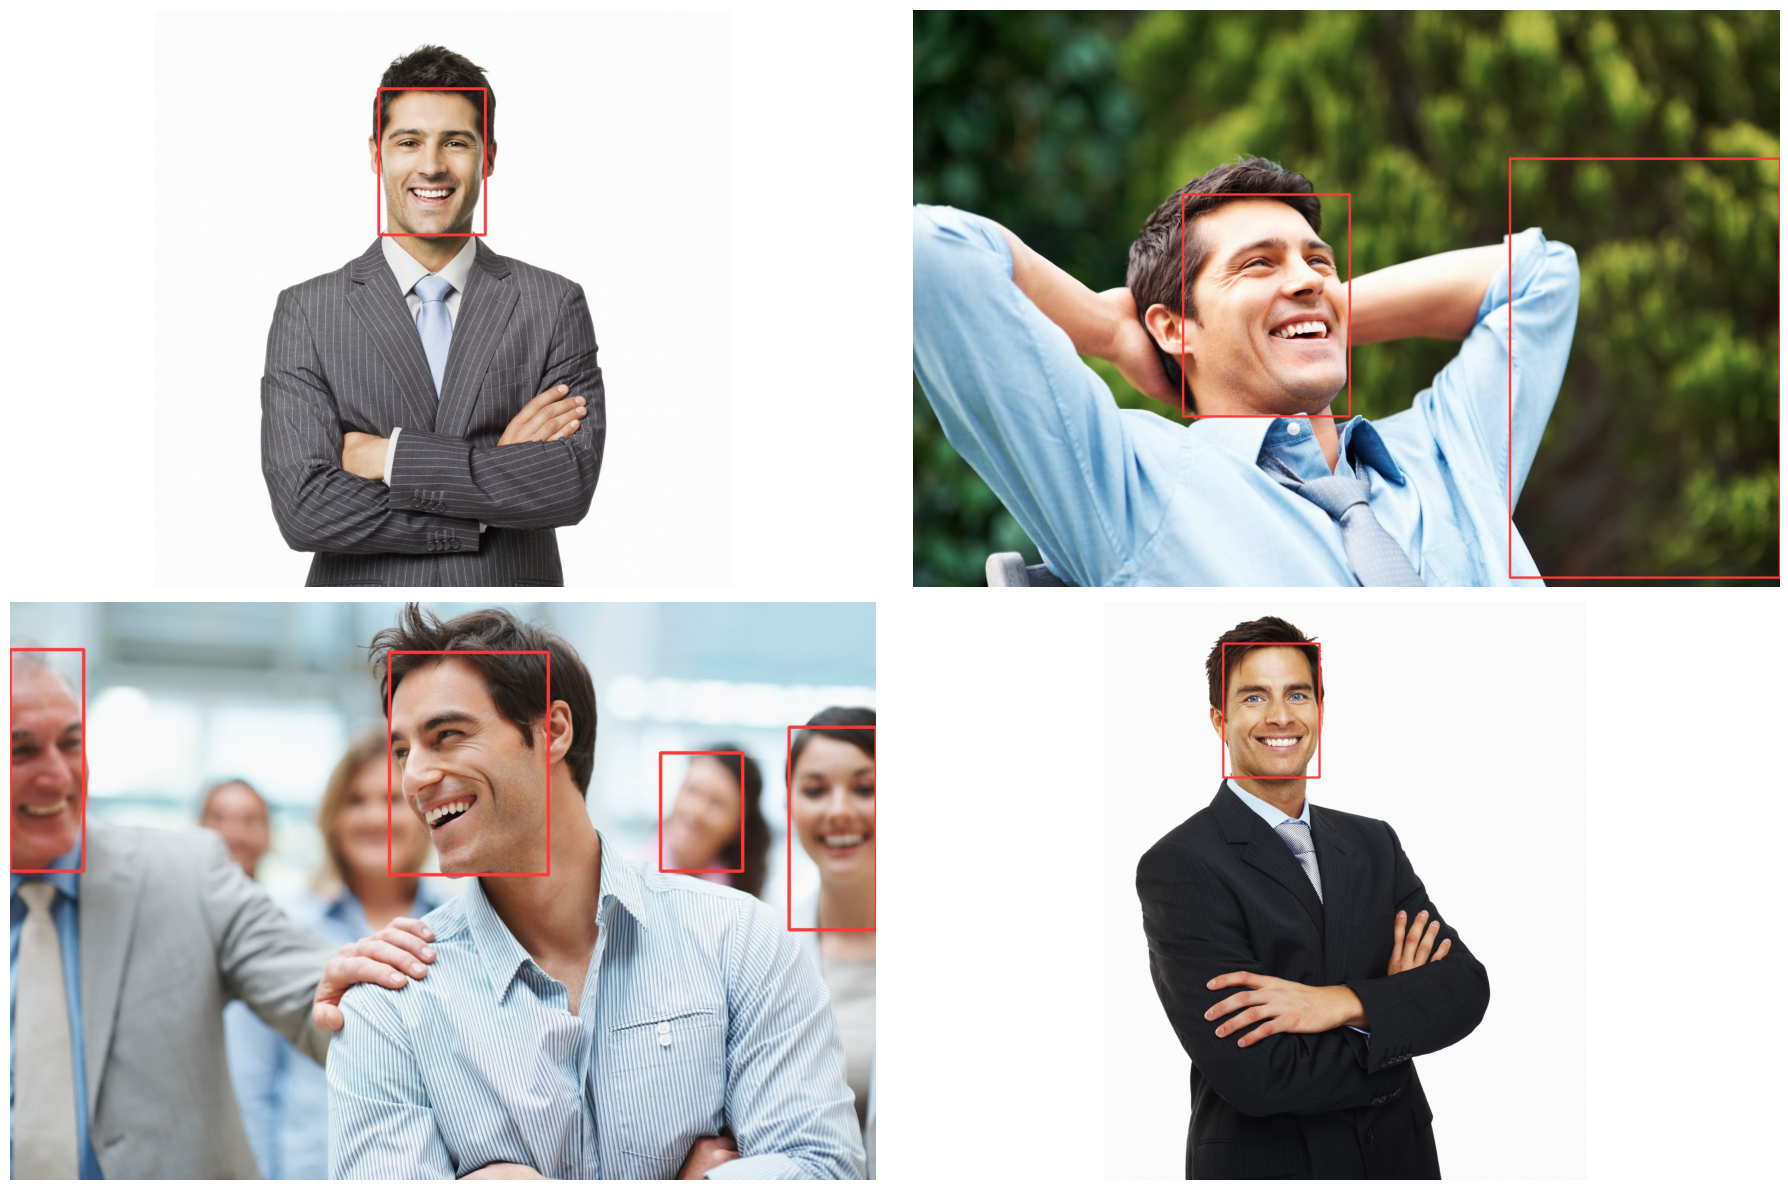

In [12]:
visualize('runs/detect/yolov8m_v8_50e_infer1280/')

In [13]:
!yolo export model=./content/yolov8m.pt format=tflite

Ultralytics YOLOv8.0.227 рџљЂ Python-3.8.10 torch-2.1.2+cpu CPU (13th Gen Intel Core(TM) i9-13900K)
YOLOv8m summary (fused): 218 layers, 25886080 parameters, 0 gradients, 78.9 GFLOPs

PyTorch: starting from 'content\yolov8m.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (49.7 MB)

TensorFlow SavedModel: starting export with tensorflow 2.10.1...

ONNX: starting export with onnx 1.15.0 opset 17...
ONNX: simplifying with onnxsim 0.4.35...
ONNX: export success вњ… 6.5s, saved as 'content\yolov8m.onnx' (98.9 MB)
TensorFlow SavedModel: running 'onnx2tf -i "content\yolov8m.onnx" -o "content\yolov8m_saved_model" -nuo --non_verbose'
Estimated count of arithmetic ops: 82.140 G  ops, equivalently 41.070 G  MACs
Estimated count of arithmetic ops: 82.140 G  ops, equivalently 41.070 G  MACs
TensorFlow SavedModel: export success вњ… 23.0s, saved as 'content\yolov8m_saved_model' (247.5 MB)

TensorFlow Lite: starting export with tensorflow 2.10.1...
TensorFlow Lite: export

2023-12-19 10:05:52.664978: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [29]:
import numpy as np
import cv2
import torch
import onnx
import cv2
import torchvision
import tensorflow as tf
!pip install onnxruntime
!pip install onnx
def img2tensor(img: np.ndarray, mean: list, std: list, size: int = 224) -> torch.Tensor:
  t = cv2.resize(img, (size,size), interpolation=cv2.INTER_AREA)
  t = torch.from_numpy(t.astype(np.float32)/ 255.0) # 0..255->0..1
  t = t.permute(2,0,1) # hwc -> chw
  _m = torch.FloatTensor(mean).unsqueeze(1).unsqueeze(1) #cx1x1
  _s = torch.FloatTensor(std).unsqueeze(1).unsqueeze(1)
  t = (t - _m) / (_s + 1E-7)
  return t
image = cv2.imread('datasets/valid/images/1 (39).jpg', cv2.IMREAD_COLOR)
y = img2tensor(image, mean=[0, 0, 0], std=[1, 1, 1],size=640).unsqueeze(0)

You should consider upgrading via the 'c:\users\gribo\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\gribo\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [30]:
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="content/yolov8m_saved_model/yolov8m_float32.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data
input_data = np.array(y.permute(0,2,3,1))
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# get_tensor() returns a copy of the tensor data
# use tensor() in order to get a pointer to the tensor
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[[1.1397301e-02 2.4202701e-02 3.3618286e-02 ... 6.7968416e-01
   7.7419549e-01 8.8862991e-01]
  [8.6807469e-03 1.2312337e-02 2.2923565e-02 ... 8.6339855e-01
   8.6356229e-01 8.8221473e-01]
  [3.2577351e-02 5.2059378e-02 6.5663449e-02 ... 6.3392735e-01
   4.4675636e-01 2.2134815e-01]
  ...
  [1.0848296e-07 1.5002050e-07 1.4920180e-07 ... 5.7709080e-06
   4.2728348e-06 4.0593909e-06]
  [1.1481482e-07 1.3437442e-07 1.2478087e-07 ... 3.6102476e-06
   3.2803071e-06 3.0840954e-06]
  [8.7948933e-08 1.0373831e-07 9.6712995e-08 ... 2.7872327e-06
   2.7339197e-06 2.8740637e-06]]]


In [31]:
output_data.shape

(1, 84, 8400)

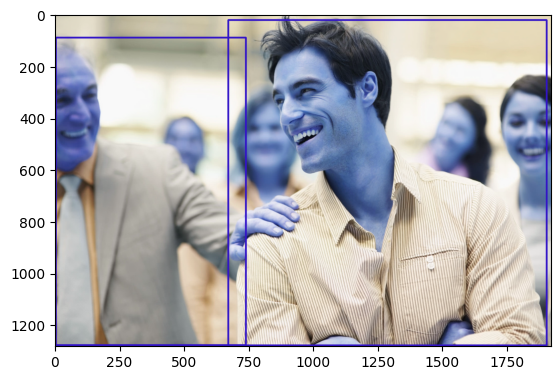

In [32]:
out = output_data.copy()
out[:, :4, :] *= 640


def xywh2xyxy(x):
  y = np.copy(x)
  y[..., 0] = x[..., 0] - x[..., 2] / 2  # top left x
  y[..., 1] = x[..., 1] - x[..., 3] / 2  # top left y
  y[..., 2] = x[..., 0] + x[..., 2] / 2  # bottom right x
  y[..., 3] = x[..., 1] + x[..., 3] / 2  # bottom right y
  return y

kx = image.shape[1] / 640
ky = image.shape[0] / 640

elem_out = out.transpose(0, 2, 1).squeeze()
#print(elem_out.shape)

boxes = elem_out[:, :4] * np.array([[kx, ky, kx, ky]])
boxes = xywh2xyxy(boxes)
probs_max_value = elem_out[:, 4:].max(axis=1)
probs_max_index = elem_out[:, 4:].argmax(axis=1)

threshold = 0.99

filter_mask = (probs_max_value-np.min(probs_max_value))/(np.max(probs_max_value)-np.min(probs_max_value)) > threshold

f_boxes = boxes[filter_mask].astype(np.int32)
f_probs_max_value = probs_max_value[filter_mask]
f_probs_max_index = probs_max_index[filter_mask]

keeps_elements = torchvision.ops.nms(
    torch.from_numpy(f_boxes.astype(np.float32)),
    torch.from_numpy(f_probs_max_value),
    0.5
  )

f_boxes = f_boxes[keeps_elements]
f_probs_max_value = f_probs_max_value[keeps_elements]


detection_visualization = image.copy()

for detecion_id in range(len(f_boxes)):
  target_object_box = f_boxes[detecion_id]  # XcYcWH format
  target_object_prob = float(f_probs_max_value[detecion_id])

  detection_visualization = cv2.rectangle(
      detection_visualization,
      tuple(target_object_box[:2]),
      tuple(target_object_box[2:]),
      (50, 20, 200),
      5
  )

#detection_visualization = cv2.resize(detection_visualization, None, fx=1/4, fy=1/4)

#cv2.imshow('image', detection_visualization)
plt.imshow(detection_visualization)